In [1]:
# LIBRARY:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

import statsmodels as sa

%matplotlib inline
%matplotlib nbagg

%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES/

/Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES


In [4]:
# Import dataset:

df = pd.read_csv('GTEX-ALL_SAMPLES.v8.phASER.gw_phased.results.fdr_ALL.gene_info.zscores.txt.gz', sep='\t', compression='gzip')

# add column for GENE_IDs without version #:
df[['GENE_ID','ens_version']] = df['GENE_ID'].str.split('.',expand=True)

df.head()

/Users/snkravitz/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,ens_version
0,1,ENSG00000228794,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,8
1,1,ENSG00000223764,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,2
2,1,ENSG00000188976,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,10
3,1,ENSG00000187961,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,13
4,1,ENSG00000187583,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,10


In [5]:
## Filter out X-Chr genes, Imprinted genes, and HLA genes:

# Remove X-Chr:
df = df[df['CHR'] != 'X']

# Remove HLA genes:
df = df[~df['GENE_NAME'].str.contains("HLA")]

# Remove Imprinted Genes:
imprinted_df = pd.read_csv("~/Documents/Gene_Lists/GTEx_Imprinting/GTEx_Imprinted_Table_S3andS4.uniq.txt", sep=' ', names=['GENE_ID', 'chrom', 'start'])
imprinted_genes = list(imprinted_df['GENE_ID'])
#imprinted_genes
df = df[~df['GENE_ID'].isin(imprinted_genes)]

In [6]:
df.head()

,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,ens_version
0,1,ENSG00000228794,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,8
1,1,ENSG00000223764,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,2
2,1,ENSG00000188976,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,10
3,1,ENSG00000187961,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,13
4,1,ENSG00000187583,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,10


In [7]:
## Plotting q-values vs. expression (i.e. mean_counts):

# Get deciles of mean_counts:
## Where the deciles are based on the RANGE of mean_read_counts (therefore the bins will not have equal # of genes)

uniq_counts = df['mean_read_counts'].unique()

pctiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

pctile_counts = []
for p in pctiles:
    pctile_counts.append(np.percentile(uniq_counts, p, interpolation='nearest'))
    
print(pctile_counts)

# Subset df by mean read counts (deciles):
expression_dfs = []
for index, p in enumerate(pctile_counts[0:len(pctile_counts)-1]):
    lower = p
    upper = pctile_counts[index + 1]
    df_subset = df['data_qvalues'][df['mean_read_counts'].between(lower, upper)].to_frame()
    df_subset['percentile'] = (index + 1) * 10
    expression_dfs.append(df_subset)

df_pctile_vals = pd.concat(expression_dfs, ignore_index=True)

# merge percentiles with original df:
df = df.merge(df_pctile_vals['percentile'], left_index=True, right_index=True)
df.head()

[10.0, 1594.0, 3178.0, 4762.0, 6356.0, 8044.0, 10041.0, 12650.0, 16580.0, 24754.0, 299623.0]


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,ens_version,percentile
0,1,ENSG00000228794,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,8,10
1,1,ENSG00000223764,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,2,10
2,1,ENSG00000188976,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,10,10
3,1,ENSG00000187961,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,13,10
4,1,ENSG00000187583,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,10,10


<IPython.core.display.Javascript object>


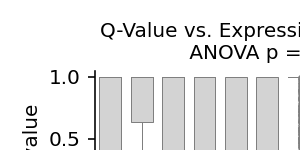

Text(0.5, 1.0, 'Q-Value vs. Expression Decile \n ANOVA p = 0')

In [6]:
# Plot Q-Vals vs. Expression (decile)
f, ax = plt.subplots(figsize=(3,2), tight_layout=True)
#plt.suptitle("Q-Value vs. Tissue Number")
sns.despine()
#sns.set_palette("husl")

anova_p = stats.f_oneway(*(df[df['percentile'] == p]['data_qvalues'].dropna() for p in np.linspace(10,100, 10)))

ax = sns.boxplot(data=df, x = 'percentile', y = 'data_qvalues', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('expression decile', fontsize=10)
ax.set_ylabel('q-value', fontsize=10)
ax.set_xticklabels(np.linspace(10,100, 10).astype(int), size=9)
ax.set_title('Q-Value vs. Expression Decile \n ANOVA p = %.2g' % anova_p.pvalue, fontsize=10)

#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.expression_decile.vs.qval.pdf', transparent=True)

In [7]:
## Plotting q-values vs. expression (i.e. mean_counts):

# Get deciles of mean_counts:
## Where the deciles are EVENLY binned, i.e. sort the data by mean_read_counts, and slice evenly

df = df.sort_values(by='mean_read_counts').reset_index()

expression_bins = np.linspace(0,df.shape[0], 20).astype(int)
print(expression_bins)

# Subset df by mean read counts (deciles):
expression_deciles = []
for index, p in enumerate(expression_bins[0:len(expression_bins)-1]):
    lower = p
    upper = expression_bins[index + 1]
    df_subset = df.iloc[lower:upper]
    #df_subset = df['data_qvalues'][df['mean_read_counts'].between(lower, upper)].to_frame()
    df_subset['percentile'] = (index + 1) * 5
    expression_deciles.append(df_subset)
    
df_pctile_vals = pd.concat(expression_deciles, ignore_index=True)

[      0  469972  939944 1409916 1879889 2349861 2819833 3289806 3759778
 4229750 4699723 5169695 5639667 6109640 6579612 7049584 7519557 7989529
 8459501 8929474]


<ipython-input-7-2333964bdf76>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['percentile'] = (index + 1) * 5


<IPython.core.display.Javascript object>


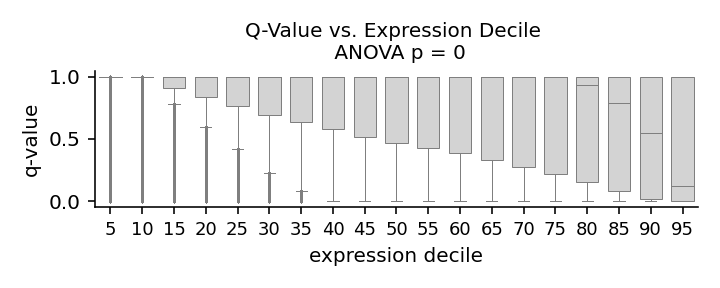

In [9]:
# Plot Q-Vals vs. Expression (decile)
f, ax = plt.subplots(figsize=(5,2), tight_layout=True)
#plt.suptitle("Q-Value vs. Tissue Number")
sns.despine()

anova_p = stats.f_oneway(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['data_qvalues'].dropna() for p in np.linspace(5,95, 19)))

ax = sns.boxplot(data=df_pctile_vals, x = 'percentile', y = 'data_qvalues', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('expression decile', fontsize=10)
ax.set_ylabel('q-value', fontsize=10)
ax.set_xticklabels(np.linspace(5,95, 19).astype(int), size=9)
ax.set_title('Q-Value vs. Expression Decile \n ANOVA p = %.2g' % anova_p.pvalue, fontsize=10)
             
#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.expression_bins.vs.qval.png', dpi=400)

In [15]:
## Plotting q-values vs. expression (i.e. med_tpms) as RegPlot:


## First get the median TPM across tissues (from GTEx data downloads):
med_tpms = pd.read_csv('/Users/snkravitz/Documents/GTEx_Summary_Data/GTEx_v8_StudyFiles/GTEx.v8.all-tissues.gene_median_tpm.info.txt', sep='\t')
med_tpms[['GENE_ID','ens_version']] = med_tpms['GENE_ID'].str.split('.',expand=True)
#print(med_tpms.head())

# Merge median Z-score to med_tpms
df_tpms = med_tpms[['GENE_ID', 'median_tpms']].merge(df[['GENE_ID', 'GENE_NAME', 'gene_start', 'gene_stop', 'SUBJECT_ID', 'tissue_num', 'data_qvalues', 'mean_read_counts', 'daee_pctile_fdr_0p1', 'z_score']], how='right', on='GENE_ID')
df_tpms.head()


,GENE_ID,median_tpms,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_qvalues,mean_read_counts,daee_pctile_fdr_0p1,z_score
0,ENSG00000228794,5.943850,LINC01128,825137,859446,GTEX-SE5C,14.0,0.655684,58.0,0.178744,0.315991
1,ENSG00000223764,2.177720,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,38.0,0.268293,0.915775
2,ENSG00000188976,54.511350,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,178.0,0.090226,-0.276891
3,ENSG00000187961,12.104000,KLHL17,960586,965715,GTEX-SE5C,15.0,1.000000,24.0,0.071882,-0.399756
4,ENSG00000187583,0.683007,PLEKHN1,966496,975108,GTEX-SE5C,7.0,1.000000,96.0,0.083039,-0.325026
5,ENSG00000131591,8.134765,C1orf159,1081817,1116361,GTEX-SE5C,17.0,1.000000,47.0,0.075235,-0.377295
6,ENSG00000272141,0.129493,RP11-465B22.8,1169356,1170343,GTEX-SE5C,6.0,1.000000,90.0,0.037037,-0.633139
7,ENSG00000078808,129.835500,SDF4,1216907,1232031,GTEX-SE5C,17.0,1.000000,362.0,0.121406,-0.068051
8,ENSG00000162576,53.268900,MXRA8,1352688,1361777,GTEX-SE5C,3.0,0.658790,17.0,0.461806,2.211894
9,ENSG00000221978,157.939500,CCNL2,1386481,1399328,GTEX-SE5C,3.0,1.000000,15.0,0.033639,-0.655898


<IPython.core.display.Javascript object>


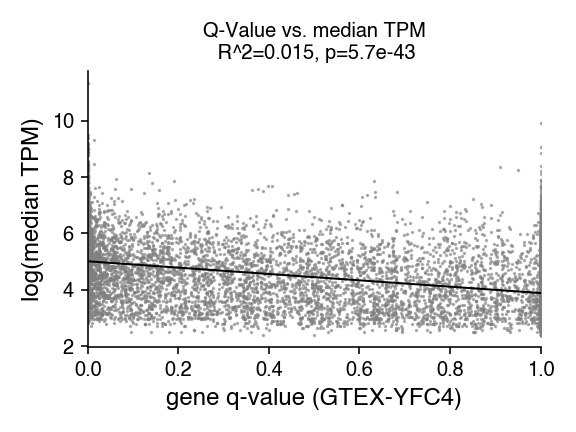

Text(0.5, 1.0, 'Q-Value vs. median TPM\n R^2=0.015, p=5.7e-43')

In [30]:
## Regplot of q-val vs. log(median TPMs) for GTEX-YFC4

f, ax = plt.subplots(figsize=(4,3), tight_layout=True)
sns.despine()

df_tpm = df_tpms[df_tpms['SUBJECT_ID'] == 'GTEX-YFC4']

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tpm['data_qvalues'],df_tpm['median_tpms'])
r_squared = r_value ** 2

ax = sns.regplot(data=df_tpms, x=df_tpm['data_qvalues'], y=np.log1p(df_tpm['median_tpms']), fit_reg=True, truncate=True, ci=95, scatter_kws={"color":"grey", "s": 0.5, "alpha": 0.6, 'rasterized': True}, line_kws={"color":"black", "lw":1})
ax.set_xlabel('gene q-value (GTEX-YFC4)', fontsize=12, fontweight='light')
ax.set_ylabel('log(median TPM)', fontsize=12, fontweight='light')
#ax.set_ylim(0, 8)
#ax.set_xlim(0, 20)
ax.set_title('Q-Value vs. median TPM\n R^2={0:.2g}, p={1:.2g}'.format(r_squared,p_value), fontsize=10)

#plt.show()


#f.savefig('/Users/snkravitz/Desktop/q-val_figs/GTEX-YFC4.all-tissues.expression.vs.q-val.regplot.pdf', dpi=400, transparent=True)



In [24]:
df_tpms[df_tpms['SUBJECT_ID'] == 'GTEX-YFC4'].shape

(12512, 11)